# NOTEBOOK PRODUCING FIGURE X, Y P3D PAPER


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from forestflow.P3D_cINN import P3DEmulator
from forestflow.plots.test_sims import plot_p1d_test_sims, plot_p3d_test_sims
from forestflow.utils import params_numpy2dict

from matplotlib import rcParams

rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

In [4]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 2)
print(path_program)
sys.path.append(path_program)

/home/jchaves/Proyectos/projects/lya/ForestFlow/


## LOAD P3D ARCHIVE

In [5]:
%%time
folder_lya_data = path_program + "/data/best_arinyo/"
folder_interp = path_program + "/data/plin_interp/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)
print(len(Archive3D.training_data))

1650
CPU times: user 13.3 s, sys: 942 ms, total: 14.3 s
Wall time: 15.1 s


## TRAIN EMULATOR

In [7]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,  # 0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,  # 15
    Archive=Archive3D,
    Nrealizations=1000,
    model_path=path_program+"/data/emulator_models/mpg_hypercube.pt",
)

## TEST EMULATOR TEST SIMULATIONS

In [8]:
Nsim = 30
Nz = 11
zs = np.flip(np.arange(2, 4.6, 0.25))

k_Mpc = Archive3D.training_data[0]["k3d_Mpc"]
mu = Archive3D.training_data[0]["mu3d"]

k_mask = (k_Mpc < 4) & (k_Mpc > 0)

k_Mpc = k_Mpc[k_mask]
mu = mu[k_mask]

k_p1d_Mpc_all = Archive3D.training_data[0]["k_Mpc"]
k_p1d_Mpc = Archive3D.training_data[0]["k_Mpc"]
k1d_mask = (k_p1d_Mpc < 5) & (k_p1d_Mpc > 0)
k_p1d_Mpc = k_p1d_Mpc[k1d_mask]
norm = k_p1d_Mpc / np.pi
norm_all = k_p1d_Mpc_all / np.pi

In [6]:
sim_labels = [
    "mpg_central",
    "mpg_seed",
    "mpg_growth",
    "mpg_neutrinos",
    "mpg_curved",
    "mpg_running",
    "mpg_reio",
]

In [9]:
sim_labels = [
    "mpg_central",
    "mpg_seed",
]

#### Loop over test sims, emulator prediction

In [10]:
P3D_testsims = np.zeros((len(sim_labels), Nz, k_Mpc.shape[0]))
P1D_testsims = np.zeros((len(sim_labels), Nz, k_p1d_Mpc.shape[0]))
z_testsims = np.zeros((len(sim_labels), Nz))
arinyo_testsims = np.zeros((len(sim_labels), Nz, 8))

for ii, sim_label in enumerate(sim_labels):
    test_sim = Archive3D.get_testing_data(
        sim_label, force_recompute_plin=False
    )
    z_grid = [d["z"] for d in test_sim]

    for iz, z in enumerate(z_grid):
        test_sim_z = [d for d in test_sim if d["z"] == z]
        
        out = p3d_emu.predict_P3D_Mpc(
            sim_label=sim_label, 
            z=z, 
            emu_params=test_sim_z[0],
            kpar_Mpc = k_p1d_Mpc
        )

        P3D_testsims[ii, iz] = out['p3d']
        P1D_testsims[ii, iz] = out['p1d']
        z_testsims[ii, iz] = z
        arinyo_testsims[ii, iz] = out["coeffs_Arinyo"]

/home/jchaves/Proyectos/projects/lya/ForestFlow/forestflow/P3D_cINN.py:443: UserWarning: Covariance matrix returned for p3d_arinyo.reshape(-1)
  warn("Covariance matrix returned for p3d_arinyo.reshape(-1)")


#### Loop over test sims, true P1D and P3D

In [11]:
P3D_testsims_true = np.zeros((len(sim_labels), Nz, k_Mpc.shape[0]))
P1D_testsims_true = np.zeros((len(sim_labels), Nz, k_p1d_Mpc.shape[0]))
P1D_testsims_true_all = np.zeros((len(sim_labels), Nz, k_p1d_Mpc_all.shape[0]))

for ii, sim_label in enumerate(sim_labels):
    test_sim =  Archive3D.get_testing_data(
        sim_label, force_recompute_plin=False
    )
    z_grid = [d["z"] for d in test_sim]

    for iz, z in enumerate(z_grid):
        test_sim_z = [d for d in test_sim if d["z"] == z]

        # p3d from sim
        p3d_sim = test_sim_z[0]["p3d_Mpc"][p3d_emu.k_mask]

        P3D_testsims_true[ii, iz] = test_sim_z[0]["p3d_Mpc"][k_mask]
        P1D_testsims_true[ii, iz] = test_sim_z[0]["p1d_Mpc"][k1d_mask]
        P1D_testsims_true_all[ii, iz] = test_sim_z[0]["p1d_Mpc"]

#### Loop over test sims, P1D and P3D from MCMC Arinyo


In [12]:
P3D_testsims_Arinyo = np.zeros((len(sim_labels), Nz, k_Mpc.shape[0]))
P1D_testsims_Arinyo = np.zeros((len(sim_labels), Nz, k_p1d_Mpc.shape[0]))
arinyo_fit = np.zeros((len(sim_labels), Nz, 8))
P1D_testsims_Arinyo_all = np.zeros((len(sim_labels), Nz, k_p1d_Mpc_all.shape[0]))

for ii, sim_label in enumerate(sim_labels):
    # Find the index of the underscore
    underscore_index = sim_label.find("_")
    lab = sim_label[underscore_index + 1 :]
    
    flag = f"Plin_interp_sim{lab}.npy"
    file_plin_inter = folder_interp + flag
    pk_interp = np.load(file_plin_inter, allow_pickle=True).all()
    model_Arinyo = ArinyoModel(camb_pk_interp=pk_interp)

    test_sim = Archive3D.get_testing_data(sim_label, force_recompute_plin=False)
    z_grid = [d["z"] for d in test_sim]

    for iz, z in enumerate(z_grid):
        test_sim_z = [d for d in test_sim if d["z"] == z]

        # load arinyo module

        BF_arinyo = test_sim_z[0]["Arinyo"]
        # print(sim_label)
        # BF_arinyo = test_sim_z[0]["Arinyo_minin"]

        p3d_arinyo = model_Arinyo.P3D_Mpc(z, k_Mpc, mu, BF_arinyo)        
        p1d_arinyo = model_Arinyo.P1D_Mpc(z, k_p1d_Mpc, parameters=BF_arinyo)

        P3D_testsims_Arinyo[ii, iz] = p3d_arinyo
        P1D_testsims_Arinyo[ii, iz] = p1d_arinyo
        P1D_testsims_Arinyo_all[ii, iz] = model_Arinyo.P1D_Mpc(z, k_p1d_Mpc_all, parameters=BF_arinyo)
        # arinyo_fit[ii, iz] = BF_arinyo

### Define fractional errors

In [13]:
fractional_error_P3D_bench = (P3D_testsims_Arinyo / P3D_testsims_true - 1)
fractional_error_P1D_bench = (P1D_testsims_Arinyo / P1D_testsims_true - 1)

fractional_error_P3D_arinyo = (P3D_testsims / P3D_testsims_Arinyo - 1)
fractional_error_P1D_arinyo = (P1D_testsims / P1D_testsims_Arinyo - 1)

fractional_error_P3D_sims = (P3D_testsims / P3D_testsims_true - 1)
fractional_error_P1D_sims = (P1D_testsims / P1D_testsims_true - 1)

## PLOT P1D

In [15]:
folder = "/home/jchaves/Proyectos/projects/lya/data/forestflow/figures/"

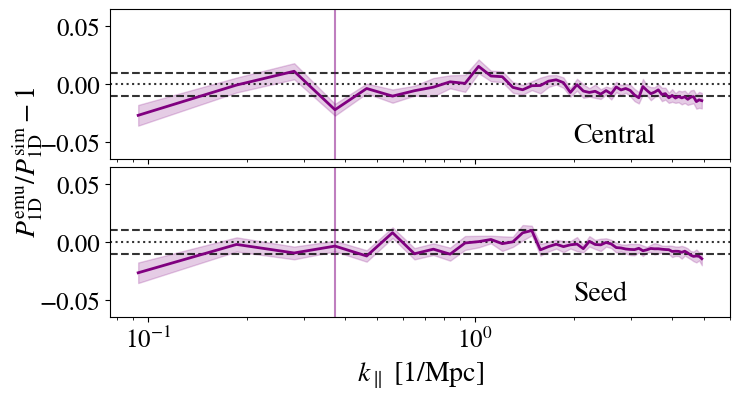

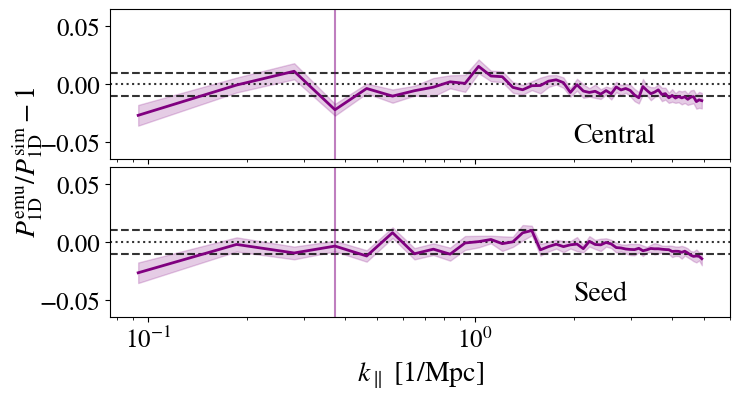

In [20]:
savename = folder + "test_cosmo/test_cosmo_P1D_ideal"
for ext in [".png", ".pdf"]:
    plot_p1d_test_sims(
        sim_labels,
        k_p1d_Mpc,
        fractional_error_P1D_sims,
        savename=savename+ext,
        fontsize=20,
    );

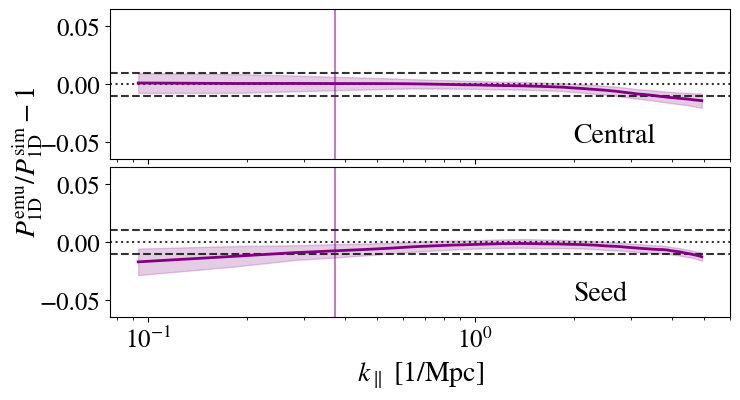

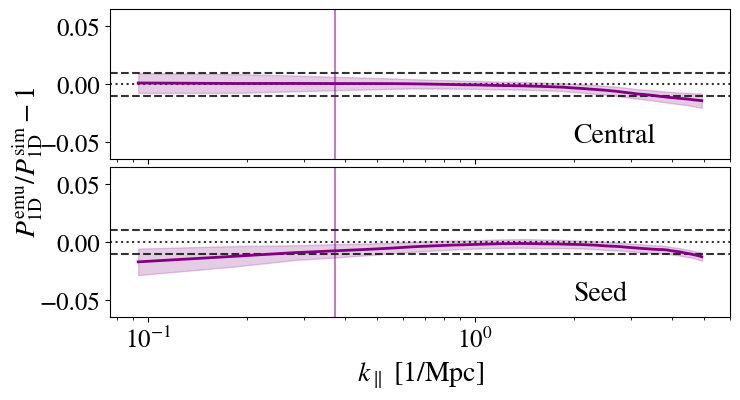

In [21]:
savename = folder + "test_cosmo/test_cosmo_P1D_smooth_ideal"
for ext in [".png", ".pdf"]:
    plot_p1d_test_sims(
        sim_labels,
        k_p1d_Mpc,
        fractional_error_P1D_arinyo,
        savename=savename+ext,
        fontsize=20,
    )

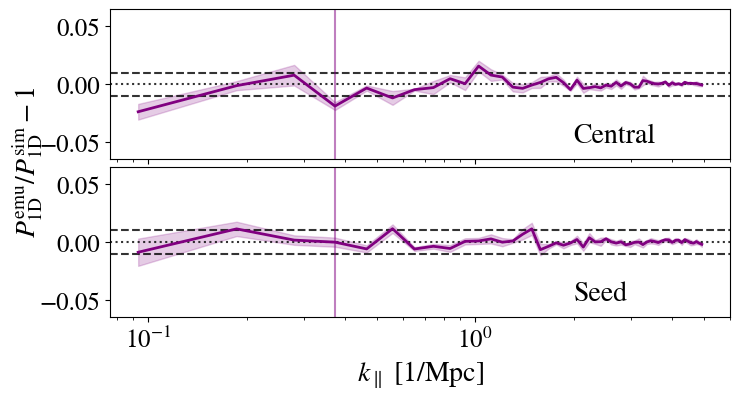

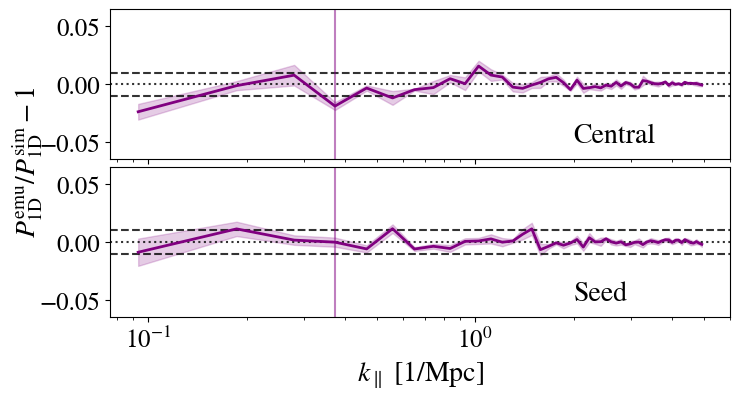

In [22]:
savename = folder + "test_cosmo/test_cosmo_P1D_fit_ideal"
for ext in [".png", ".pdf"]:
    plot_p1d_test_sims(
        sim_labels,
        k_p1d_Mpc,
        fractional_error_P1D_bench,
        savename=savename+ext,
        fontsize=20,
    )

## PLOT P3D

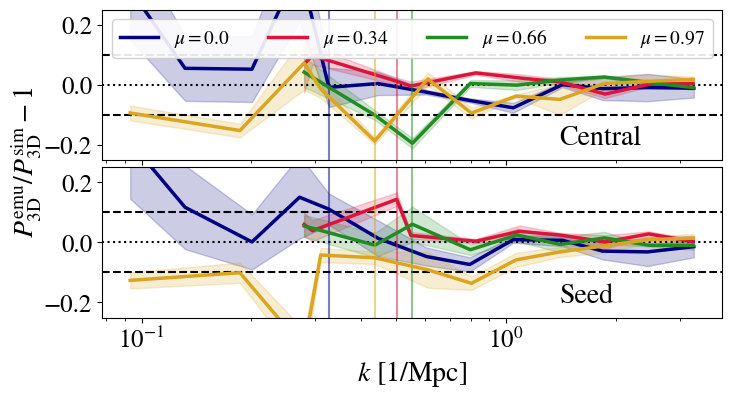

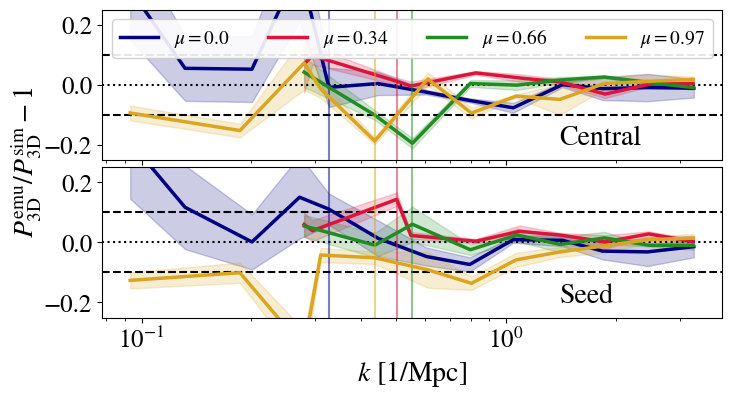

In [29]:
savename = folder + "test_cosmo/test_cosmo_P3D_ideal"
for ext in [".png", ".pdf"]:
    plot_p3d_test_sims(
        sim_labels,
        k_Mpc,
        mu,    
        k_mask,
        fractional_error_P3D_sims,
        savename=savename+ext,
        fontsize=20,
    )

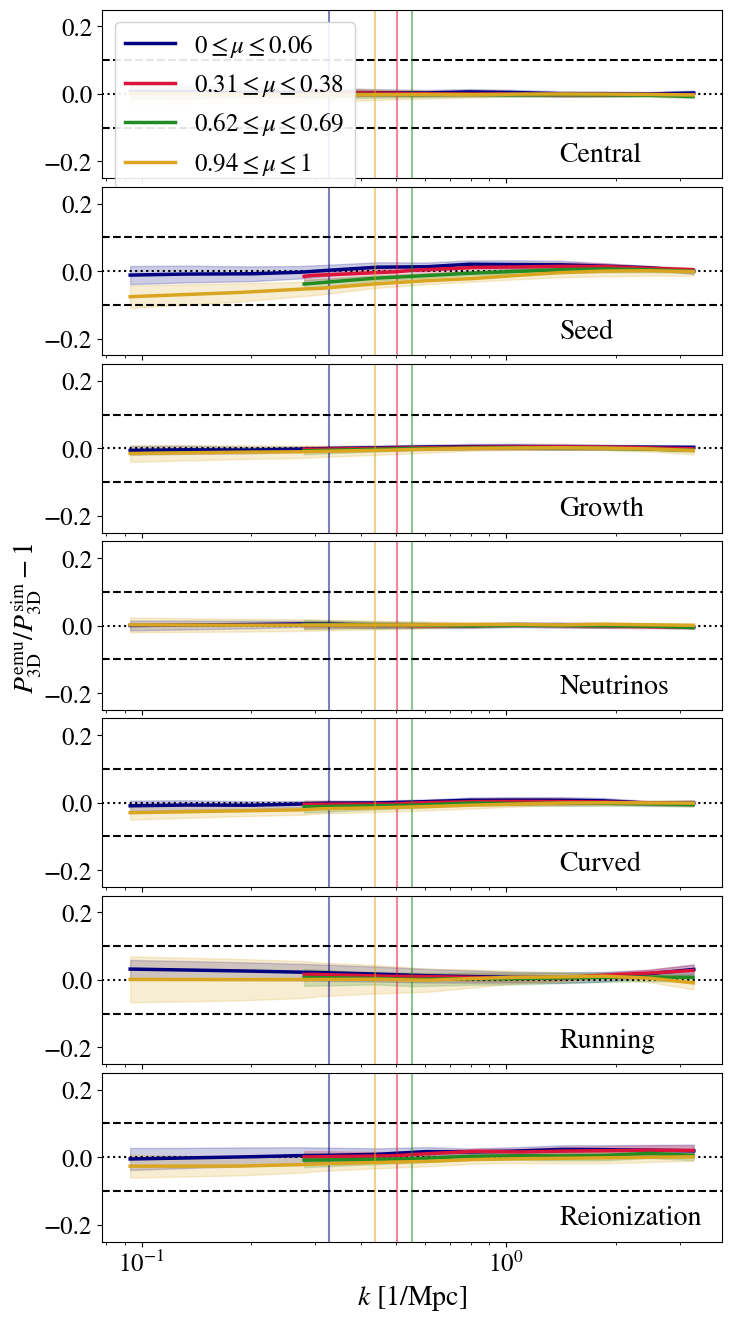

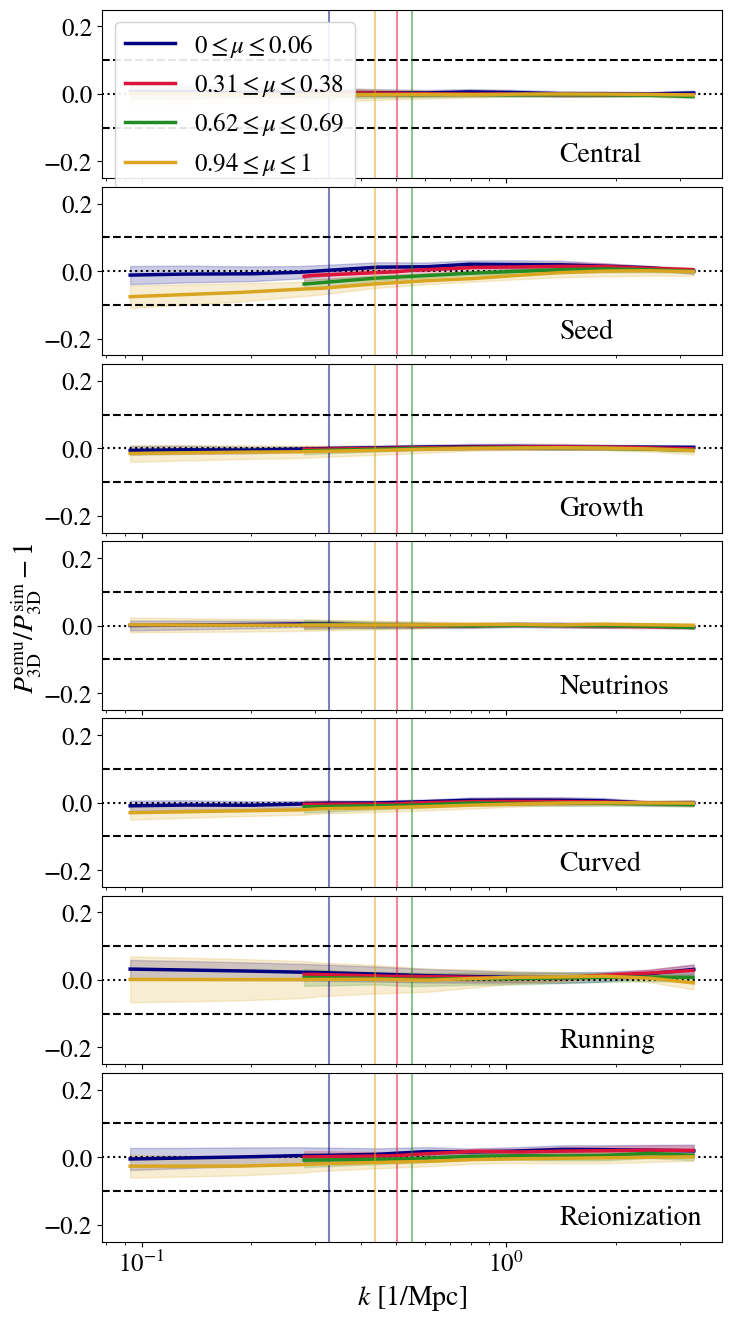

In [21]:
savename = folder + "test_cosmo/test_cosmo_P3D_smooth.pdf"
plot_p3d_test_sims(
    sim_labels,
    k_Mpc,
    mu,    
    k_mask,
    fractional_error_P3D_arinyo,
    savename=savename,
    fontsize=20,
)
savename = folder + "test_cosmo/test_cosmo_P3D_smooth.png"
plot_p3d_test_sims(
    sim_labels,
    k_Mpc,
    mu,    
    k_mask,
    fractional_error_P3D_arinyo,
    savename=savename,
    fontsize=20,
)

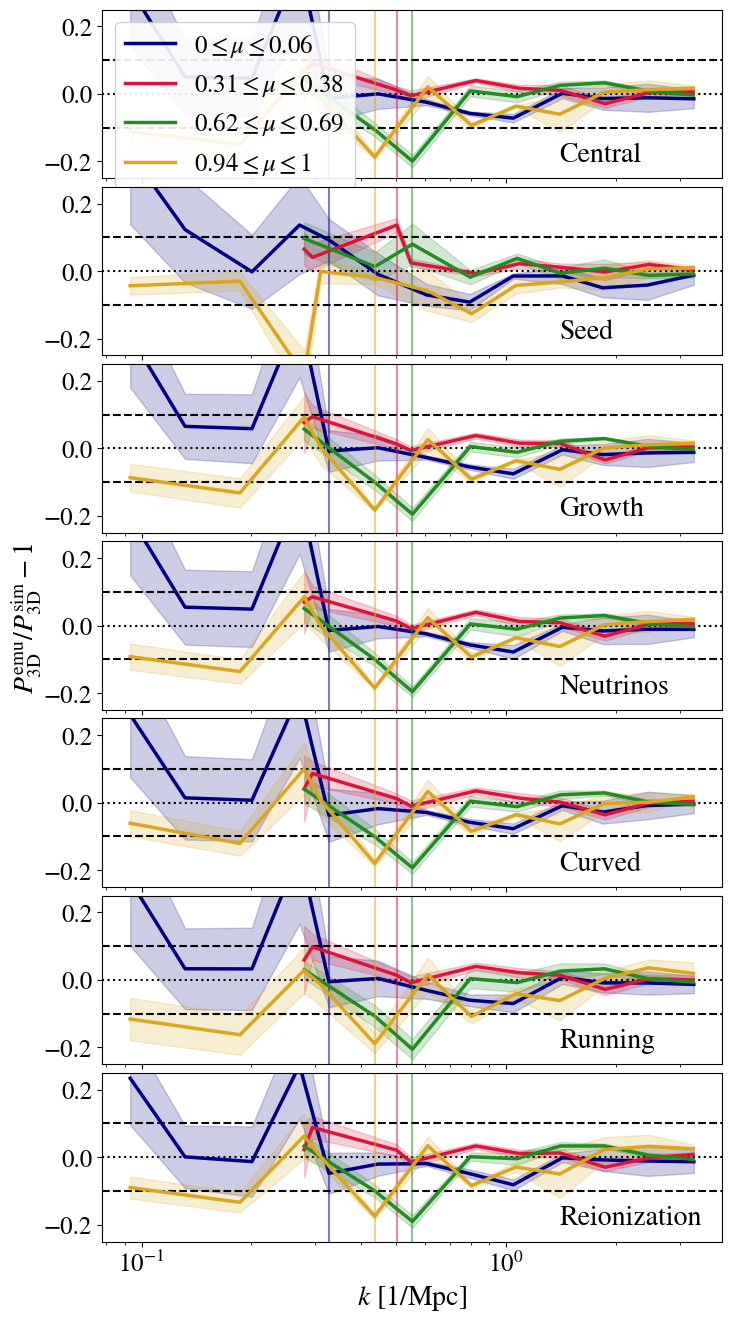

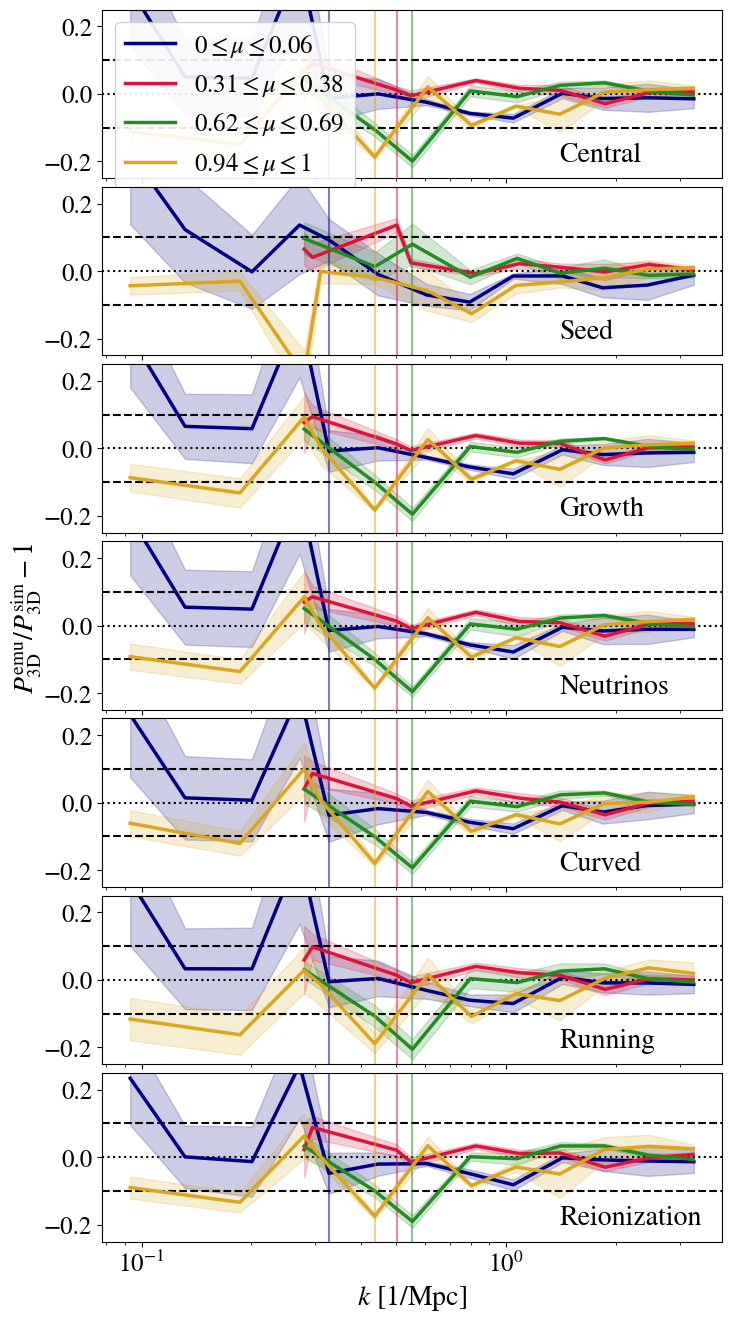

In [22]:
savename = folder + "test_cosmo/test_cosmo_P3D_fit.pdf"
plot_p3d_test_sims(
    sim_labels,
    k_Mpc,
    mu,    
    k_mask,
    fractional_error_P3D_bench,
    savename=savename,
    fontsize=20,
)
savename = folder + "test_cosmo/test_cosmo_P3D_fit.png"
plot_p3d_test_sims(
    sim_labels,
    k_Mpc,
    mu,    
    k_mask,
    fractional_error_P3D_bench,
    savename=savename,
    fontsize=20,
)

## CHECK RUNNING SIMULATION

In [35]:
index = sim_labels.index('mpg_running')

Text(0.5, 0, '$k$ [1/Mpc]')

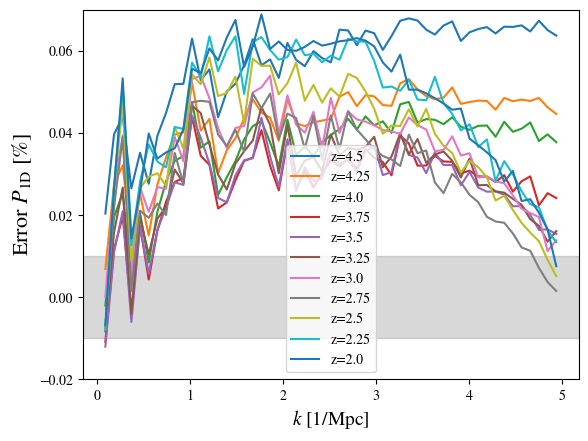

In [39]:
for iz,z in enumerate(z_grid):
    plt.plot(p1d_k, fractional_error_P1D_sims[index, iz], label = f'z={z_grid[iz]}')
    
plt.legend(fontsize=10)

plt.axhspan(-0.01, 0.01, color="gray", alpha=0.3)
plt.ylim(-0.02, 0.07)

plt.ylabel(r"Error $P_{\rm 1D}$ [%]",  fontsize=16)
    
plt.xlabel('$k$ [1/Mpc]', fontsize=14 )   

Text(0.5, 0, '$k$ [1/Mpc]')

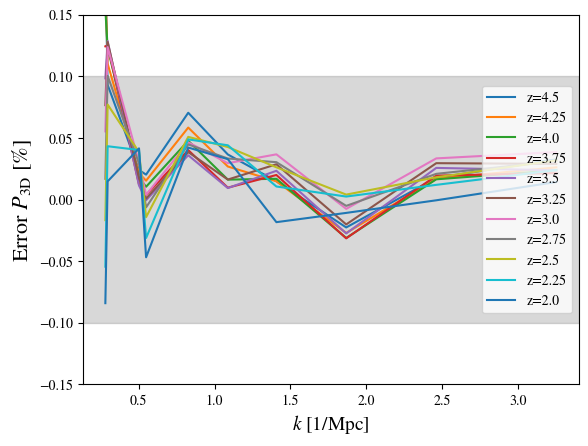

In [40]:
mu_mask = (mu >= 0.31) & (mu <= 0.38)
k_masked = k_Mpc[mu_mask]
for iz,z in enumerate(z_grid):
    plt.plot(k_masked, fractional_error_P3D_sims[index, iz][mu_mask], label = f'z={z_grid[iz]}')
    
plt.legend(fontsize=10)

plt.axhspan(-0.10, 0.10, color="gray", alpha=0.3)
plt.ylim(-0.15, 0.15)

plt.ylabel(r"Error $P_{\rm 3D}$ [%]",  fontsize=16)
    
plt.xlabel('$k$ [1/Mpc]', fontsize=14 )   

### Look at Arinyo parameters

In [ ]:
sim_label ='mpg_running'
arinyo_emu = np.zeros(shape=(len(z_grid),8))
arinyo_mcmc = np.zeros(shape=(len(z_grid),8))
test_sim = Archive3D.get_testing_data(sim_label, force_recompute_plin=True)
                       
for iz, z in enumerate(z_grid):

    test_sim_z = [d for d in test_sim if d["z"] == z]
    
    arinyo_emu[iz] = p3d_emu.predict_Arinyos(test_sim=test_sim_z)
                         
    arinyo_mcmc[iz] = np.fromiter(test_sim_z[0]["Arinyo"].values(), dtype=float) 
    



#### plot values

In [ ]:
params =  [r"$b$", r"$\beta$", "$q_1$", "$k_{vav}$", "$a_v$", "$b_v$", "$k_p$", "$q_2$"]
colors = plt.cm.tab10(np.linspace(0, 1, len(params)))


for ip, param in enumerate(params):
    plt.scatter(np.arange(8), arinyo_emu[ip, :], marker='_', label='ForestFlow' if ip == 0 else "", color = colors[ip])
    plt.scatter(np.arange(0.3, 8.3, 1), arinyo_mcmc[ip, :], marker='x',  label='MCMC' if ip == 0 else "", color = colors[ip])

plt.xticks(np.arange(8), params)
plt.legend(fontsize=14)
plt.ylabel('Parameter value', fontsize=16)
plt.show()

#### plot ratios

In [ ]:
sim_label ='mpg_central'
arinyo_emu_central = np.zeros(shape=(len(z_grid),8))
arinyo_mcmc_central = np.zeros(shape=(len(z_grid),8))
test_sim = Archive3D.get_testing_data(sim_label, force_recompute_plin=True)
                       
for iz, z in enumerate(z_grid):
    test_sim_z = [d for d in test_sim if d["z"] == z]
    arinyo_emu_central[iz] = p3d_emu.predict_Arinyos(test_sim=test_sim_z)                
    arinyo_mcmc_central[iz] = np.fromiter(test_sim_z[0]["Arinyo"].values(), dtype=float) 
ratio_central = arinyo_emu_central / arinyo_mcmc_central

In [ ]:
sim_label ='mpg_running'
arinyo_emu_running = np.zeros(shape=(len(z_grid),8))
arinyo_mcmc_running = np.zeros(shape=(len(z_grid),8))
test_sim = Archive3D.get_testing_data(sim_label, force_recompute_plin=True)
                       
for iz, z in enumerate(z_grid):
    test_sim_z = [d for d in test_sim if d["z"] == z]
    arinyo_emu_running[iz] = p3d_emu.predict_Arinyos(test_sim=test_sim_z)                
    arinyo_mcmc_running[iz] = np.fromiter(test_sim_z[0]["Arinyo"].values(), dtype=float) 
ratio_running = arinyo_emu_running / arinyo_mcmc_running

In [ ]:
params =  [r"$b$", r"$\beta$", "$q_1$", "$k_{vav}$", "$a_v$", "$b_v$", "$k_p$", "$q_2$"]
colors = plt.cm.tab10(np.linspace(0, 1, len(params)))


for ip, param in enumerate(params):
    plt.scatter(np.arange(8), ratio_central[ip, :], marker='_', label='Central' if ip == 0 else "", color = colors[ip])
    plt.scatter(np.arange(0.3, 8.3, 1), ratio_running[ip, :], marker='x',  label='Running' if ip == 0 else "", color = colors[ip])

plt.xticks(np.arange(8), params)
plt.legend(fontsize=14)
plt.ylabel('Emulated / MCMC  parameters', fontsize=16)

plt.ylim(0,2)
plt.show()

### Check running, move below

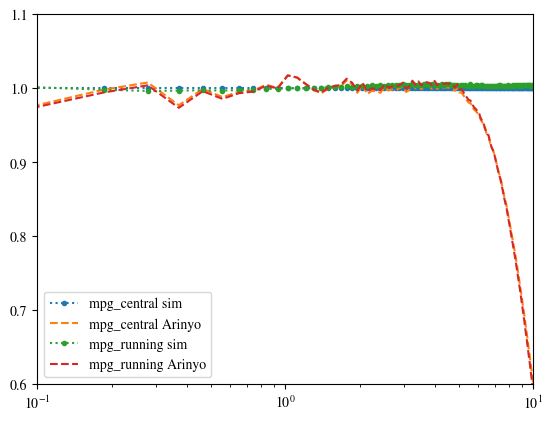

In [34]:
snap = 5
index = [0, -2]
for ii, sim_label in enumerate(["mpg_central", "mpg_running"]):
    # plt.plot(k_p1d_Mpc, P1D_testsims_true[index[ii], snap]/P1D_testsims_true[index[0], snap], ".")
    plt.plot(k_p1d_Mpc_all, P1D_testsims_true_all[index[ii], snap]/P1D_testsims_true_all[index[0], snap], ".:", label=sim_label+" sim")
    # plt.plot(k_p1d_Mpc, P1D_testsims_Arinyo[index[ii], snap]/P1D_testsims_true[index[0], snap]/norm)
    plt.plot(k_p1d_Mpc_all, P1D_testsims_Arinyo_all[index[ii], snap]/P1D_testsims_true_all[index[0], snap], "--", label=sim_label+" Arinyo")
plt.xscale('log')
# plt.yscale('log')
plt.xlim(0.1, 10)
plt.ylim(0.6, 1.1)
plt.legend()
plt.savefig("test_arinyo_10.png")

[-0.28223258  1.06109744  0.54283687  0.83704859  0.56718388  1.85698277
 13.94418526  0.23814491]
[-0.28137262  1.06340408  0.54106221  0.83790472  0.56916964  1.85612375
 14.02272463  0.2347287 ]


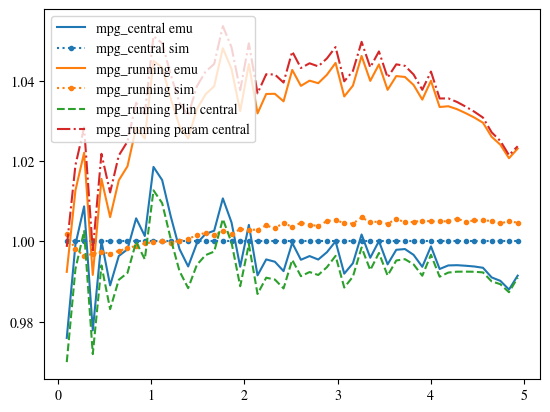

In [153]:
params =  [r"$b$", r"$\beta$", "$q_1$", "$k_{vav}$", "$a_v$", "$b_v$", "$k_p$", "$q_2$"]
print(arinyo_testsims[0, 5])
print(arinyo_testsims[-2, 5])
index = [0, -2]
snap = 5
z = z_grid[snap]
model_Arinyo = []
div = P1D_testsims_true[index[0], snap]
for ii, sim_label in enumerate(["mpg_central", "mpg_running"]):
    # Find the index of the underscore
    underscore_index = sim_label.find("_")
    lab = sim_label[underscore_index + 1 :]

    # test_sim = Archive3D.get_testing_data(sim_label, force_recompute_plin=False)
    # z_grid = [d["z"] for d in test_sim]

    # load arinyo module
    # lab = "central"
    flag = f"Plin_interp_sim{lab}.npy"
    file_plin_inter = folder_interp + flag
    pk_interp = np.load(file_plin_inter, allow_pickle=True).all()
    model_Arinyo.append(ArinyoModel(camb_pk_interp=pk_interp))
    
for ii, sim_label in enumerate(["mpg_central", "mpg_running"]):
    col = "C"+str(ii)
    BF_arinyo = params_numpy2dict(arinyo_testsims[index[ii], snap])
    # print(sim_label)
    # BF_arinyo = test_sim_z[0]["Arinyo_minin"]

    # test_p3d_arinyo = model_Arinyo.P3D_Mpc(z, k_Mpc, mu, BF_arinyo)        
    test_p1d_arinyo = model_Arinyo[ii].P1D_Mpc(z, k_p1d_Mpc, parameters=BF_arinyo) * norm

    plt.plot(k_p1d_Mpc, test_p1d_arinyo/div, col, label=sim_label+" emu")
    plt.plot(k_p1d_Mpc, P1D_testsims_true[index[ii], snap]/div, col+ ".:", label=sim_label+" sim")

test_p1d_arinyo = model_Arinyo[0].P1D_Mpc(z, k_p1d_Mpc, parameters=BF_arinyo) * norm

plt.plot(k_p1d_Mpc, test_p1d_arinyo/div, "C2--", label=sim_label+" Plin central")
BF_arinyo = params_numpy2dict(arinyo_testsims[index[0], snap])
test_p1d_arinyo = model_Arinyo[1].P1D_Mpc(z, k_p1d_Mpc, parameters=BF_arinyo) * norm
plt.plot(k_p1d_Mpc, test_p1d_arinyo/div, "C3-.", label=sim_label+" param central")
plt.legend()
plt.savefig("test_running.png")

In [128]:
from lace.setup_simulations import read_genic
from lace.cosmo import camb_cosmo, fit_linP
kp_Mpc = 0.7
z = z_grid[snap]

In [135]:
pair_dir = '/home/jchaves/Proyectos/projects/lya/LaCE/data/sim_suites/Australia20/running_sim/'

genic_fname = pair_dir + "/sim_plus/paramfile.genic"
cosmo_params = read_genic.camb_from_genic(genic_fname)

# setup CAMB object
sim_cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)

# compute linear power parameters at each z (in Mpc units)
linP_zs = fit_linP.get_linP_Mpc_zs(sim_cosmo, [z], kp_Mpc)

In [133]:
linP_zs_central = linP_zs
linP_zs_central

[{'Delta2_p': 0.31079419600143793,
  'n_p': -2.3000470882011004,
  'alpha_p': -0.21536695205681683,
  'f_p': 0.9842181826479233}]

In [136]:
linP_zs_running = linP_zs
linP_zs_running

[{'Delta2_p': 0.310794196001437,
  'n_p': -2.3000470882011017,
  'alpha_p': -0.20036695205682262,
  'f_p': 0.9842182206041636}]

In [137]:
test_central[5]['Delta2_p']

0.3107109675962955

In [138]:
test_running[5]['Delta2_p']

0.3107109675962945

In [85]:
test_running[5]['Plin_for_p1d'].shape

(676, 99)

In [77]:
test_central[5].keys()

dict_keys(['ind_axis', 'ind_phase', 'sim_label', 'ind_rescaling', 'ind_snap', 'cosmo_params', 'kp_Mpc', 'z', 'dkms_dMpc', 'Delta2_p', 'n_p', 'alpha_p', 'f_p', 'mF', 'p3d_Mpc', 'k3d_Mpc', 'mu3d', 'T0', 'gamma', 'sigT_Mpc', 'kF_Mpc', 'k_Mpc', 'p1d_Mpc', 'val_scaling', 'Arinyo', 'Arinyo_25', 'Arinyo_75', 'model', 'Plin', 'Plin_for_p1d'])

(0.99, 1.01)

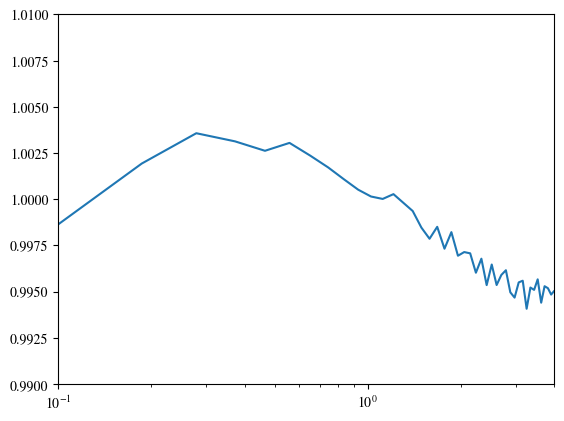

In [84]:
plt.plot(test_central[5]['k_Mpc'], test_central[5]['p1d_Mpc']/test_running[5]['p1d_Mpc'])
plt.xlim(0.1, 4)
plt.xscale("log")
plt.ylim(0.99, 1.01)

In [100]:
test_central[5]['Plin']

(20, 16)

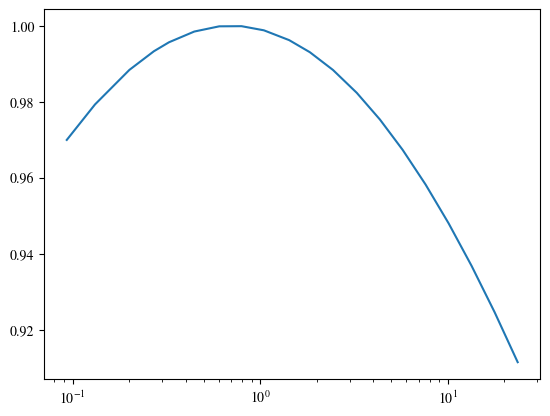

In [154]:
plt.plot(test_central[5]['k3d_Mpc'][:,0], 
         (test_central[5]['Plin']/test_running[5]['Plin'])[:,0])
# plt.xlim(0.1, 10)
plt.xscale("log")
# plt.ylim(0.96, 1.02)
plt.savefig("plin_running.png")

In [ ]:
test_running[5]['Plin_for_p1d']

In [86]:
test_central = Archive3D.get_testing_data(
    "mpg_central", force_recompute_plin=False
)
test_running = Archive3D.get_testing_data(
    "mpg_running", force_recompute_plin=False
)